# HW03: Preprocessing

In [1]:
# Import Libraries
import os
import nltk
import csv
import string
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim import models
from gensim import similarities

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## Simpsons Dataset

### Import data

In [2]:
# Set pandas columns option
pd.set_option('display.max_colwidth', 1000)
pd.set_option("max_rows", 30)

# Import Simpsons data
raw_df = pd.read_csv('./data/raw/simpsons_dataset.csv', sep = ',')

# Glimpse at the dataset
raw_df.head(10)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,"The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we'll have our final statements. Martin?"
5,Martin Prince,I don't think there's anything left to say.
6,Edna Krabappel-Flanders,Bart?
7,Bart Simpson,Victory party under the slide!
8,NaN,NaN
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!


In [3]:
# Top 10 characters by spoken words
raw_df.groupby(['raw_character_text']).count().sort_values(by=['spoken_words'], ascending=False).head(10)

,spoken_words
raw_character_text,
Homer Simpson,27850
Marge Simpson,13172
Bart Simpson,12995
Lisa Simpson,10756
C. Montgomery Burns,3077
Moe Szyslak,2808
Seymour Skinner,2385
Ned Flanders,2056
Grampa Simpson,1802


In [4]:
# Filter by main characters
simpsons_df= raw_df.loc[(raw_df['raw_character_text']=='Homer Simpson') 
                        | (raw_df['raw_character_text']=='Marge Simpson') 
                        | (raw_df['raw_character_text']=='Bart Simpson') 
                        | (raw_df['raw_character_text']=='Lisa Simpson') ].dropna()


simpsons_df.head(10)

,raw_character_text,spoken_words
1,Lisa Simpson,Where's Mr. Bergstrom?
3,Lisa Simpson,That life is worth living.
7,Bart Simpson,Victory party under the slide!
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!
11,Lisa Simpson,Do you know where I could find him?
13,Lisa Simpson,"The train, how like him... traditional, yet environmentally sound."
15,Lisa Simpson,"I see he touched you, too."
17,Bart Simpson,"Hey, thanks for your vote, man."
19,Bart Simpson,"Well, you got that right. Thanks for your vote, girls."
21,Bart Simpson,"Well, don't sweat it. Just so long as a couple of people did... right, Milhouse?"


### Process Data

In [5]:
# Colloquial dict contractions
contraction_colloq_dict = {"btw": "by the way", "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "where's":"where is"}

In [6]:
def process_text(text, p, tokenizer, lemmatizer):
    """ Applies standard pre-processing to given text.
    
    Args:
        p (gensim.parsing.porter.PorterStemmer): stemmer object.
        tokenizer (nltk.tokenize.regexp.RegexpTokenizer): tokenizr object.
        text (str): text to preprocess.
    
    Returns:
        list: preprocessed text.
    
    """
    # Converts to lowercase
    text_lc = text.lower()
    
    # Replace colloquial terms
    for word in text_lc.split():
        if word in list(contraction_colloq_dict.keys()):
            text_lc = text_lc.replace(word, contraction_colloq_dict[word])
    
    # Removes stopwords
    #text_sw = remove_stopwords(text_lc)
    
    # Stems text
    #text_stem = p.stem_sentence(text_sw)
    
    # Tokenizes text and removes punctuation
    text_tk = tokenizer.tokenize(text_lc)
    
    # Lemmatizes text
    text_lm = []
    for word in text_tk:
        text_lm.append(lemmatizer.lemmatize(word))
        
    
    # Returns preprocessed text
    return text_lm


In [7]:
def process_dataset(words, tags):
    """ Applies standard pre-processing to given dataset
    
    Args:
        words (str): List of strings to be processed.
        tags (str): List of tags to be encoded.
    
    Returns:
        X_train (str): List of tokenized text.
        y_train (int): List of encoded tags.
        X_test (str):List of tokenized text.
        y_test (int): List of encoded tags.
    
    """
    # Simple preprocess to words
    
    # Creates PorterStemmer instance.
    p = PorterStemmer()
    # Creates lemmatizer instance
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # Creates RegexpTokenizer (removes punctuation signs)
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    
    # Apply preprocess to the whole dataset
    X = []
    for line in words:
        # Simple preprocess using gensim
        #X.append(simple_preprocess(line, deacc=False, min_len=1, max_len=15))
        
        # Full preprocess
        X.append(process_text(line, p, tokenizer, lemmatizer))
        
    # Glipse at preprocess
    print('Example of a tokenized line:')
    print(words[0]) 
    print(X[0])
    
    # Encode tags
    
    # Create label encoder
    oe = OneHotEncoder()
    oe.fit(np.array(list(set(tags))).reshape(-1, 1))

    # Apply encoder to the whole dataset
    y = oe.transform(np.array(tags).reshape(-1, 1)).toarray()
        
    # Split dataset into training, validation and test
    X_aux, X_test, y_aux, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, test_size=0.1765, random_state=42)
    
    # Returns preprocessed dataset
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
# Extract text from df
simpsons_words = simpsons_df['spoken_words'].values
# Extract tags from df
simpsons_tags = simpsons_df['raw_character_text'].values

# Apply preprocess
Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test = process_dataset(simpsons_words, simpsons_tags)

Example of a tokenized line:
Where's Mr. Bergstrom?
['where', 'is', 'mr', 'bergstrom']


In [9]:
def plot_sentences_length(tokenized_sentences, title='Sentence Length Histogram'):
    """ Plot histogram with sentences length
    
    Args:
        tokenized_sentences (str): List of tokenized sentences
    
    """
    sentences_length = []
    for x in tokenized_sentences:
        sentences_length.append(len(x))
        
    bins= np.max(np.array(sentences_length))
    
    fig = plt.figure(figsize=(12,8))
    plt.hist(np.array(sentences_length), bins=bins)
    plt.xlim([1, 50])
    plt.xlabel('Sentence Length')
    plt.ylabel('Count')
    plt.title(title)
    plt.grid(True)
    
    plt.show()
    
    print('Tamaño promedio (mean) de la sentencias:')
    print(np.mean(np.array(sentences_length)))
    
    print('Tamaño medio (median) de la sentencias:')
    print(np.median(np.array(sentences_length)))

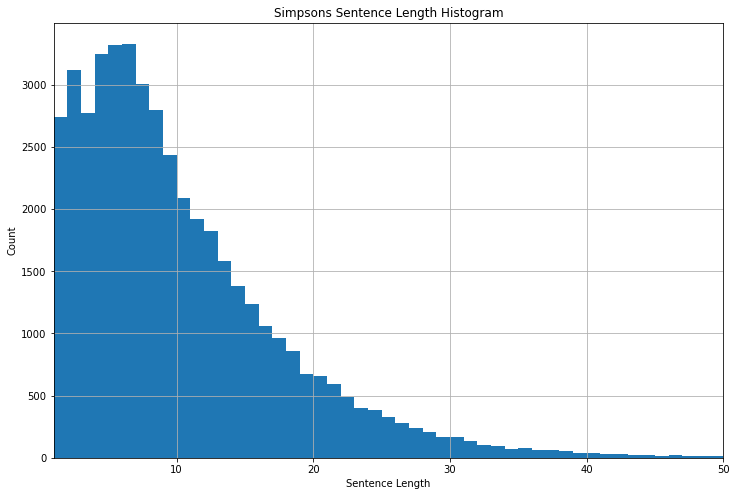

Tamaño promedio (mean) de la sentencias:
9.937978340942676
Tamaño medio (median) de la sentencias:
8.0


In [10]:
plot_sentences_length(Xs_train, 'Simpsons Sentence Length Histogram')

In [11]:
# Save preprocess texts
with open('./data/simpsons/X_train.csv',"w", newline='') as f:
    csv.writer(f).writerows(Xs_train)
    
with open('./data/simpsons/X_val.csv',"w", newline='') as f:
    csv.writer(f).writerows(Xs_val)
    
with open('./data/simpsons/X_test.csv',"w", newline='') as f:
    csv.writer(f).writerows(Xs_test)

In [12]:
# Save preprocess dataset
np.savetxt('./data/simpsons/y_train.csv', ys_train)
np.savetxt('./data/simpsons/y_val.csv', ys_val)
np.savetxt('./data/simpsons/y_test.csv', ys_test)

## Friends Dataset

### Import Data

In [13]:
# Import Friends data

# Text
friends_words = []
# Tag
friends_tags = []

# Dataset dir
for dirname, _, filenames in os.walk('./data/raw/friends_dataset'):
    # Files in dir
    for filename in filenames:
        # Open file
        with open(os.path.join(dirname, filename), encoding="utf8") as fp:
            # Lines in file
            line = fp.readline()
            while line:
                data  = line.strip().split(": ")
                # Verify not a blank line
                if len(data) > 1:
                    # Append tags and words
                    if data[0] == 'Monica' or data[0] == 'Joey' or data[0] == 'Chandler' or data[0] == 'Phoebe' or data[0] == 'Ross' or data[0] == 'Rachel':
                        friends_words.append(data[1])
                        friends_tags.append(data[0])
                line = fp.readline()
                

In [14]:
# Glimpse at the dataset
friends_df = pd.DataFrame()
friends_df['character'] = friends_tags
friends_df['spoken_words'] = friends_words
friends_df.head(10)

,character,spoken_words
0,Monica,There's nothing to tell! He's just some guy I work with!
1,Joey,"C'mon, you're going out with the guy! There's gotta be something wrong with him!"
2,Chandler,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?"
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!"
5,Monica,"Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex."
6,Chandler,Sounds like a date to me.
7,Chandler,"Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked."
8,Chandler,"Then I look down, and I realize there's a phone... there."
9,Joey,Instead of...?


In [15]:
# Top 10 characters by spoken words
friends_df.groupby(['character']).count().sort_values(by=['spoken_words'], ascending=False).head(10)

,spoken_words
character,
Rachel,8506
Ross,8262
Chandler,7686
Monica,7620
Joey,7572
Phoebe,6831


### Process data

In [16]:
# Apply preprocess
Xf_train, Xf_val, Xf_test, yf_train, yf_val, yf_test = process_dataset(friends_words, friends_tags)

Example of a tokenized line:
There's nothing to tell! He's just some guy I work with!
['there', 'is', 'nothing', 'to', 'tell', 'he', 'is', 'just', 'some', 'guy', 'i', 'work', 'with']


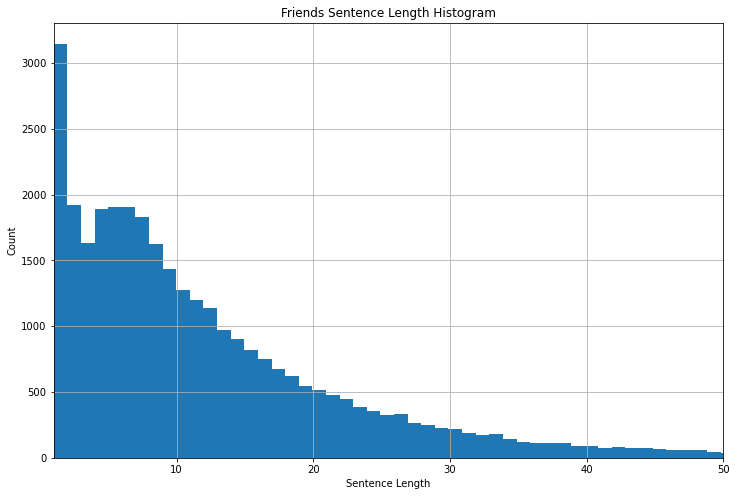

Tamaño promedio (mean) de la sentencias:
12.569808188860199
Tamaño medio (median) de la sentencias:
9.0


In [17]:
plot_sentences_length(Xf_train, 'Friends Sentence Length Histogram')

In [18]:
# Save preprocess texts
with open('./data/friends/X_train.csv',"w", newline='') as f:
    csv.writer(f).writerows(Xf_train)
    
with open('./data/friends/X_val.csv',"w", newline='') as f:
    csv.writer(f).writerows(Xf_val)
    
with open('./data/friends/X_test.csv',"w", newline='') as f:
    csv.writer(f).writerows(Xf_test)

In [19]:
# Save preprocess tags
np.savetxt('./data/friends/y_train.csv', yf_train)
np.savetxt('./data/friends/y_val.csv', yf_val)
np.savetxt('./data/friends/y_test.csv', yf_test)